<a href="https://colab.research.google.com/github/kha-dija1/aslprep/blob/master/Auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import modules

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
import os
from keras.models import load_model
from skimage.transform import resize
import pickle
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout
from keras.layers.merge import concatenate
from keras.models import Model

# load the datasets

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving DaeTrainedModelMetaData.pkl to DaeTrainedModelMetaData.pkl
Saving DaeTrainedModel.h5 to DaeTrainedModel.h5
User uploaded file "DaeTrainedModelMetaData.pkl" with length 1786 bytes
User uploaded file "DaeTrainedModel.h5" with length 1237688 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dMRaw.nii.gz to dMRaw.nii.gz
User uploaded file "dMRaw.nii.gz" with length 3782505 bytes


# class DAE

In [ ]:
class Dae:
  def __init__(self, dMRaw=None, dMRawFile=None):
     self.modelFile = 'DaeTrainedModel.h5'
     self.modelMetaData = 'DaeTrainedModelMetaData.pkl'
     self.model = load_model(self.modelFile)
     f = open(self.modelMetaData, 'rb')
     self.mp = pickle.load(f)
     f.close()
     self.loss = self.mp['loss']
     self.val_loss = self.mp['val_loss']
     self.epochs = np.arange(1, self.loss.size + 1)
     if dMRawFile is None:
       if dMRaw is None:
          dMRawFile = 'dMRaw.nii.gz'
          nii = nib.load(dMRawFile)
          self.dMraw = nii.get_data().astype('float32')
       else:
         self.dMraw = dMRaw
     else:
       if dMRaw is not None:
         print('** Warning: both dMRaw and dMRawFile supplied. Using dMRawFile...')
       nii = nib.load(dMRawFile)
       self.dMraw = nii.get_data().astype('float32')
     if self.dMraw.ndim == 4:
       [self.xres, self.yres, self.zres, self.tres] = self.dMraw.shape
     if self.dMraw.ndim == 3:
       [self.xres, self.yres, self.zres] = self.dMraw.shape
       self.tres = None
     if self.dMraw.ndim == 2:
       [self.xres, self.yres] = self.dMraw.shape
       self.zres = None
       self.tres = None
     if self.dMraw.ndim < 2 or self.dMraw.ndim > 4:
        print('** Error: input data must consist of a 2D, 3D or 4D array **')
  def applyModel(self):
    self.rescale_res = 128
    self.xres0 = self.xres
    self.yres0 = self.yres
    if self.xres0 != self.rescale_res or self.yres0 != self.rescale_res:
       self.dMraw0 = self.dMraw
       self.xres = self.rescale_res
       self.yres = self.rescale_res
       if self.dMraw.ndim == 4:
         self.dMraw = np.zeros((self.rescale_res, self.rescale_res, self.zres, self.tres))
         for r in range(self.tres):
           for k in range(self.zres):
             thisSlice = self.dMraw0[:, :, k, r]
             self.dMraw[:, :, k, r] = resize(thisSlice, (self.rescale_res, self.rescale_res), anti_aliasing=True)
       if self.dMraw.ndim == 3:
         self.dMraw = np.zeros((self.rescale_res, self.rescale_res, self.zres))
         for k in range(self.zres):
           thisSlice = self.dMraw0[:, :, k]
           self.dMraw[:, :, k] = resize(thisSlice, (self.rescale_res, self.rescale_res), anti_aliasing=True)
       if self.dMraw.ndim == 2:
         self.dMraw = resize(self.dMraw, (self.rescale_res, self.rescale_res), anti_aliasing=True)
    self.dMraw[np.isnan(self.dMraw)] = 0.0
    self.dMraw[np.isinf(self.dMraw)] = 0.0
    dat_test_vector = self.dMraw.flatten()
    uthr = np.percentile(dat_test_vector, 99.9)
    lthr = np.percentile(dat_test_vector, 0.1)
    self.dMraw = np.clip(self.dMraw, a_min=lthr, a_max=uthr)
    if self.dMraw.ndim == 4:
      noisy_image_stack = np.zeros((self.zres * self.tres, self.xres, self.yres, 1))
      predicted_image_stack = np.zeros((self.zres * self.tres, self.xres, self.yres, 1))
      dMdenoised = np.zeros((self.xres, self.yres, self.zres, self.tres))
      sctr = 0
      for t in range(self.tres):
        for k in range(self.zres):
          a = self.dMraw[:, :, k, t]
          noisy_image_stack[sctr, :, :, :] = a.reshape(self.xres, self.yres, 1)
          sctr += 1
    if self.dMraw.ndim == 3:
      predicted_image_stack = np.zeros((self.zres, self.xres, self.yres, 1))
      noisy_image_stack = np.zeros((self.zres, self.xres, self.yres, 1))
      dMdenoised = np.zeros((self.xres, self.yres, self.zres))
      for k in range(self.zres):
        a = self.dMraw[:, :, k]
        noisy_image_stack[k, :, :, :] = (a.reshape(self.xres, self.yres, 1)).astype('float32')
    if self.dMraw.ndim == 2:
      noisy_image_stack = self.dMraw.reshape(1, self.xres, self.yres, 1)
      predicted_image_stack = np.zeros((1, self.xres, self.yres, 1))
      dMdenoised = np.zeros((self.xres, self.yres))
    scale_mean = self.mp["noisy_image_stack_mean"]
    scale_std = self.mp["noisy_image_stack_std"]
    noisy_image_stack_rescaled = (noisy_image_stack - scale_mean) / scale_std
    dMdenoised_raw = self.model.predict(noisy_image_stack_rescaled)
    if self.dMraw.ndim == 4:
      sctr = 0
      for t in range(self.tres):
        for k in range(self.zres):
          thisSlice = dMdenoised_raw[sctr, :, :, 0]
          thisSlice_unscaled = (thisSlice * scale_std) + scale_mean
          predicted_image_stack[sctr, :, :, 0] = thisSlice_unscaled
          dMdenoised[:, :, k, t] = thisSlice_unscaled
          sctr += 1
    if self.dMraw.ndim == 3:
      for k in range(self.zres):
        thisSlice = dMdenoised_raw[k, :, :, 0]
        thisSlice_unscaled = (thisSlice * scale_std) + scale_mean
        predicted_image_stack[k, :, :, 0] = thisSlice_unscaled
        dMdenoised[:, :, k] = thisSlice_unscaled
    if self.dMraw.ndim == 2:
      thisSlice = dMdenoised_raw[0, :, :, 0]
      thisSlice_unscaled = (thisSlice * scale_std) + scale_mean
      predicted_image_stack[0, :, :, 0] = thisSlice_unscaled
      dMdenoised = thisSlice_unscaled
    if self.rescale_res != self.xres0 or self.rescale_res != self.yres0:
       dMdenoised0 = dMdenoised
       if self.dMraw.ndim == 4:
         dMdenoised = np.zeros((self.xres0, self.yres0, self.zres, self.tres))
         for r in range(self.tres):
            for k in range(self.zres):
              thisSlice = dMdenoised0[:, :, k, r]
              dMdenoised[:, :, k, r] = resize(thisSlice, (self.xres0, self.yres0), anti_aliasing=True)
       if self.dMraw.ndim == 3:
         dMdenoised = np.zeros((self.xres0, self.yres0, self.zres))
         for k in range(self.zres):
           thisSlice = dMdenoised0[:, :, k]
           dMdenoised[:, :, k] = resize(thisSlice, (self.xres0, self.yres0), anti_aliasing=True)
         self.dMraw = self.dMraw0
    self.dMdenoised = dMdenoised
    self.modelApplied = True
  def showSlice(self, slice=None, rep=None):
    if self.modelApplied:
      if self.dMraw.ndim == 2:
        pic = np.hstack((np.rot90(self.dMraw), np.rot90(self.dMdenoised)))
        plt.figure()
        plt.imshow(pic, cmap='gray', vmin=-10, vmax=120)
      if self.dMraw.ndim == 3:
        if slice is None:
          slice = round(self.zres / 2)
        pic = np.hstack((np.rot90(self.dMraw[:, :, slice]), np.rot90(self.dMdenoised[:, :, slice])))
        plt.figure()
        plt.imshow(pic, cmap='gray', vmin=-10, vmax=120)
      if self.dMraw.ndim == 4:
        if slice is None:
          slice = round(self.zres / 2)
        if rep is None:
          rep = 0
        pic = np.hstack((np.rot90(self.dMraw[:, :, slice, rep]), np.rot90(self.dMdenoised[:, :, slice, rep])))
        plt.figure()
        plt.imshow(pic, cmap='gray', vmin=-10, vmax=120)
    else:
      print('** Error: Model has not yet been applied to raw data - please use applyModel() method first **')
  def showTraining(self):
    plt.figure()
    plt.plot(self.epochs, self.val_loss, 'ro-')
    plt.plot(self.epochs, self.loss, 'bo-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(('validation', 'training'))

# model creation

In [ ]:
from keras import regularizers
def conv2d_block(input_tensor, n_filters=64, kernel_size=3, add_BatchNormalization=False, dropout_rate=0, weight_regularization=0, activation=True):
  if weight_regularization != 0:
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same", kernel_regularizer = regularizers.l2(weight_regularization))(input_tensor)
  else:
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(input_tensor)
  if add_BatchNormalization:
    x = BatchNormalization()(x)
  if activation:
    x = Activation("relu")(x)
  if dropout_rate != 0:
    x = Dropout(dropout_rate)(x)
  return x
def autoencoder(n_filters=64, inChannel=1):
  input_img = Input(shape=(None, None, inChannel))
  conv1 = conv2d_block(input_img, n_filters=n_filters, kernel_size=3)
  p1 = MaxPooling2D((2, 2))(conv1)
  conv2 = conv2d_block(p1, n_filters=n_filters, kernel_size=3)
  p2 = MaxPooling2D((2, 2))(conv2)
  conv3 = conv2d_block(p2, n_filters=n_filters, kernel_size=3)
  u1 = UpSampling2D((2, 2))(conv3)
  merge1 = concatenate([conv2, u1])
  conv4 = conv2d_block(merge1, n_filters=n_filters, kernel_size=3)
  u2 = UpSampling2D((2, 2))(conv4)
  merge2 = concatenate([conv1, u2])
  conv5 = conv2d_block(merge2, n_filters=1, kernel_size=3, activation=False)
  model = Model(inputs=input_img, outputs=conv5)
  return model

In [ ]:
dae=Dae()
dae.applyModel()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


In [ ]:
Autoencoder=autoencoder()
Autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
Autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   640         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 activation (Activation)        (None, None, None,   0           ['conv2d[0][0]']                 
                                64)                                                           

In [ ]:
dae.__init__(dMRaw=None, dMRawFile=None)
pickle.load(open(dae.modelMetaData, 'rb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


{'SkipFirstRep': False,
 'batch_size': 100,
 'early_stopping_epoch': 67,
 'loss': array([0.19999565, 0.14475538, 0.13236764, 0.12537155, 0.12143955,
        0.11852393, 0.11600481, 0.1138082 , 0.11177425, 0.11050731,
        0.10916214, 0.10740484, 0.10612396, 0.10462819, 0.10388868,
        0.103171  , 0.10186727, 0.10095512, 0.10063859, 0.10013843,
        0.09882344, 0.09843738, 0.09741073, 0.09687753, 0.09621349,
        0.09555318, 0.09506659, 0.09492467, 0.09397512, 0.09313456,
        0.09305478, 0.09280412, 0.09262397, 0.09238831, 0.09159068,
        0.09152666, 0.09065186, 0.09100011, 0.09013168, 0.08995497,
        0.08962757, 0.08962612, 0.08951887, 0.0886919 , 0.08855317,
        0.08847922, 0.08799244, 0.08773198, 0.08755029, 0.08729236,
        0.08729442, 0.08711925, 0.08652034, 0.08650807, 0.08619381,
        0.08644683, 0.08630571, 0.08562784, 0.08560628, 0.08574686,
        0.08486133, 0.08495716, 0.08507612, 0.08487032, 0.08469639,
        0.08438992, 0.08452083]),
 

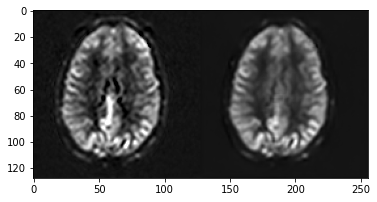

In [ ]:
dae.showSlice(slice=None, rep=None)

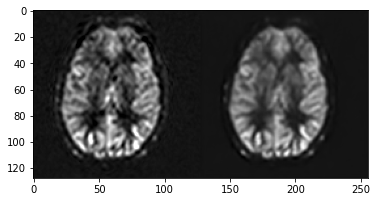

In [ ]:
dae.showSlice(slice=10, rep=5)

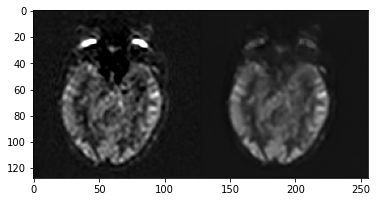

In [ ]:
dae.showSlice(slice=3)

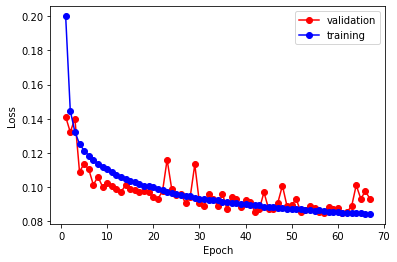

In [ ]:
dae.showTraining()

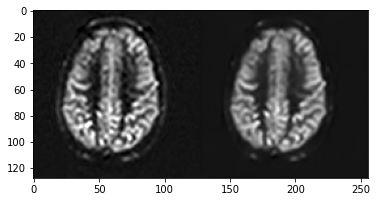

In [ ]:
dae.showSlice(slice=15)

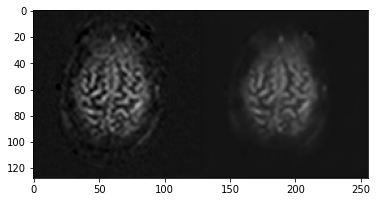

In [ ]:
dae.showSlice(slice=20, rep=4)

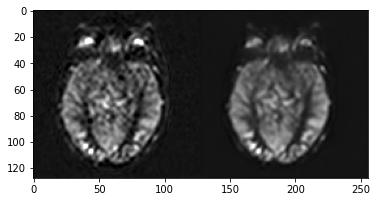

In [ ]:
dae.showSlice(slice=5)

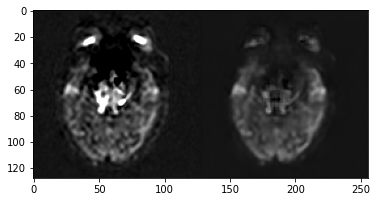

In [ ]:
dae.showSlice(slice=1)

In [ ]:
'''import math

def psnr():
  for i in range(0, len(dae.dMraw)):
    original =dae.dMraw[i]
    contrast = dae.dMdenoised[i]
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR'''

In [ ]:
psnr()

45.95118045856572

In [ ]:
import math
import os
import numpy as np

def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR


def main():
  for i,j in zip(range(11), range(11)):
    original=dae.dMraw[i]
    contrast=dae.dMdenoised[j]
    print(f"PSNR value is {psnr(original, contrast)} dB")

if __name__ == '__main__':
    main()

PSNR value is 45.95117849636557 dB
PSNR value is 48.255169347804106 dB
PSNR value is 48.43866475975283 dB
PSNR value is 47.35679701944391 dB
PSNR value is 47.85210185626685 dB
PSNR value is 47.714055373101786 dB
PSNR value is 47.445658400756614 dB
PSNR value is 47.04157949368916 dB
PSNR value is 46.796229175772496 dB
PSNR value is 46.69717568615415 dB
PSNR value is 46.43773078744055 dB


In [ ]:
psnr(dae.dMraw[15],dae.dMdenoised[15])

43.49804026942735

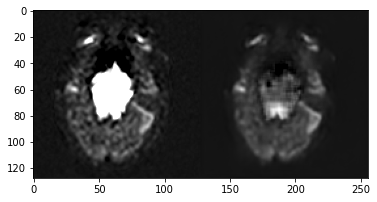

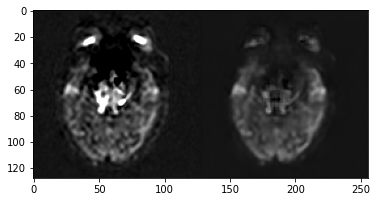

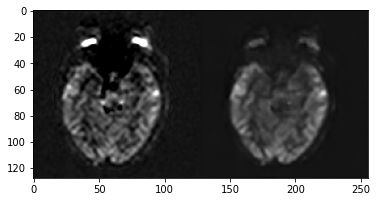

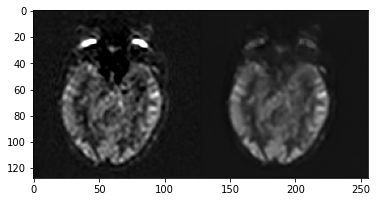

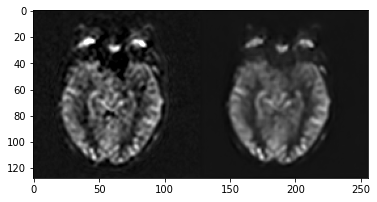

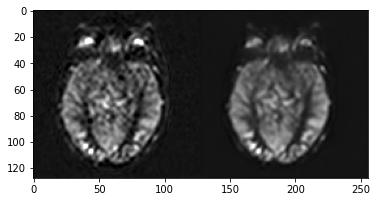

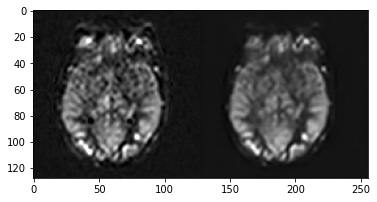

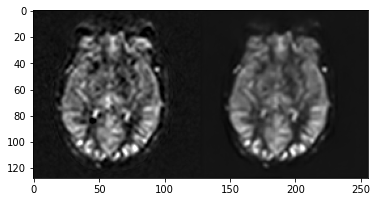

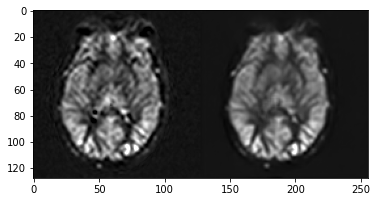

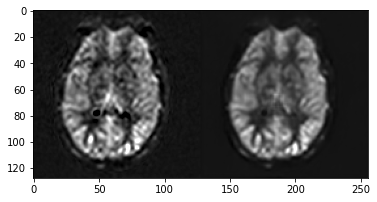

In [ ]:
for i in range(10):
  dae.showSlice(i)